In [1]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import shap

import matplotlib.pyplot as plt

# Outbreak prediction using Random Forest Experiment

Steps:
1. Split data by timestamp into training and testing set
2. Run to RF model
3. SHAP

Possible iterations: removing the static values, removing the annual values, removing both.

RandomForest in sklearn does not handle nulls, would need to remove the nulls. **In this run, the preprocessing includes:**
- Removing rows that did not contain Age statistics (Age_mean, Age_median, etc.) --- this essentially dropped the added time series rows that had no health data to them at all
- Dropped Ookla columns for now since they only match 2 years with the dataset
- RWI also removed and too many nulls --- also expected that the values would be repetitive since it is too coarse (bring back this feature if done at city level)
- population density columns are also removed for now since they contain plenty of nulls --- apparently it looks like if there are population count values in the raster, does not mean there are population density values too?

Try for next iteration:
- remove other feature
- city-level linked data?

In [2]:
PROCESSED_DIR = Path("../../data/03-processed/")
LINKED_DATA = PROCESSED_DIR / "linked_df_v1.csv"

## Load Linked Dataset

In [3]:
linked_df = pd.read_csv(LINKED_DATA)
linked_df.head()

,start_of_week,year,ADM4_PCODE,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,...,google_bldgs_count_gt_200_sqm,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct
0,2013-01-07,2013,PH097332001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,35,0.003804,15.039279,5,0.0,0.0,3611.67,76.28,0.0,0.0
1,2013-01-07,2013,PH097332001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,35,0.003804,15.039279,6,0.0,0.0,446.57,9.43,0.0,0.0
2,2013-01-07,2013,PH097332001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,35,0.003804,15.039279,7,0.0,0.0,1.36,0.03,0.0,0.0
3,2013-01-07,2013,PH097332001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,35,0.003804,15.039279,8,0.0,0.0,155.34,3.28,0.0,0.0
4,2013-01-07,2013,PH097332001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,35,0.003804,15.039279,9,0.0,0.0,0.00,0.00,0.0,0.0


In [4]:
# change pcode from string to int
linked_df["revised_pcode"] = linked_df["ADM4_PCODE"].str.lstrip("PH")
linked_df["revised_pcode"] = linked_df["revised_pcode"].astype("int")

In [5]:
linked_df["start_of_week"] = pd.to_datetime(linked_df["start_of_week"])
linked_df = linked_df.sort_values(by=["start_of_week"])

## Inspect missing data

**Listing down the reasons for nulls in the data**

- populated the missing timestamps in the data --- though the number of cases are 0, they are many nans such as the aggregation/age statistics (mean, min, max, etc.)
- male and female column breakdowns --- remove these columns --- no difference in trends
- some climate variables were Nan's (meaning that there are some weeks that did not match)
- tower_nearest_y ? <-- remove
- ookla contains nans since we only have data from 2019-2021
- missing nightlights data

In [6]:
linked_df.columns[linked_df.isnull().any()].tolist()

['Age_min',
 'Age_max',
 'Age_mean',
 'Age_median',
 'Age_std',
 'Female',
 'Male',
 'NDVI_AVG',
 'NDVI_MIN',
 'NDVI_MAX',
 'PNP_AVG',
 'PNP_MIN',
 'PNP_MAX',
 'PNP_STD',
 'PR_AVG',
 'PR_MIN',
 'PR_MAX',
 'PR_STD',
 'SPI3_AVG',
 'SPI3_MIN',
 'SPI3_MAX',
 'SPI3_STD',
 'SPI6_AVG',
 'SPI6_MIN',
 'SPI6_MAX',
 'SPI6_STD',
 'poi_count',
 'clinic_count',
 'clinic_nearest',
 'dentist_count',
 'dentist_nearest',
 'doctors_count',
 'doctors_nearest',
 'hospital_count',
 'hospital_nearest',
 'optician_count',
 'optician_nearest',
 'pharmacy_count',
 'pharmacy_nearest',
 'atm_count',
 'atm_nearest',
 'bank_count',
 'bank_nearest',
 'college_count',
 'college_nearest',
 'community_centre_count',
 'community_centre_nearest',
 'comms_tower_count',
 'comms_tower_nearest',
 'convenience_count',
 'convenience_nearest',
 'fire_station_count',
 'fire_station_nearest',
 'kindergarten_count',
 'kindergarten_nearest',
 'lighthouse_count',
 'lighthouse_nearest',
 'market_place_count',
 'market_place_nearest',

In [7]:
# try filtering to check how much we have
filtered_linked_df = linked_df.copy()

In [8]:
# filter to year with population
filtered_linked_df = filtered_linked_df[
    (filtered_linked_df["year"] >= 2014) & (filtered_linked_df["year"] <= 2020)
]
# try removing those without health data (age, etc)
filtered_linked_df = filtered_linked_df.dropna(
    subset=[
        "Age_min",
        "Age_max",
        "Age_mean",
        "Age_median",
        "Age_std",
    ]
)
# remove ookla for now
filtered_linked_df = filtered_linked_df.drop(
    columns=[
        # ookla
        "fixed_mean_avg_d_kbps_mean",
        "fixed_mean_avg_u_kbps_mean",
        "fixed_mean_avg_lat_ms_mean",
        "fixed_mean_num_tests_mean",
        "fixed_mean_num_devices_mean",
        "mobile_mean_avg_d_kbps_mean",
        "mobile_mean_avg_u_kbps_mean",
        "mobile_mean_avg_lat_ms_mean",
        "mobile_mean_num_tests_mean",
        "mobile_mean_num_devices_mean",
        # rwi
        "RWI_max",
        "RWI_mean",
        "RWI_median",
        "RWI_min",
        "RWI_std",
        # others
        "Year",
        "tower_nearest_y",
        # population density
        # apparently there are nulls
        # even if there's population count values
        "pop_density_mean",
        "pop_density_median",
        "pop_density_stdev",
        "pop_density_min",
        "pop_density_max",
    ]
)
filtered_linked_df

,start_of_week,year,ADM4_PCODE,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
132862,2014-01-06,2014,PH097332074,5.0,2.0,20.0,11.0,11.0,7.648529,2.0,...,0.000536,3.815725,7,0.0,0.0,0.00,0.00,0.0,0.0,97332074
132863,2014-01-06,2014,PH097332074,5.0,2.0,20.0,11.0,11.0,7.648529,2.0,...,0.000536,3.815725,8,0.0,0.0,0.00,0.00,0.0,0.0,97332074
132864,2014-01-06,2014,PH097332074,5.0,2.0,20.0,11.0,11.0,7.648529,2.0,...,0.000536,3.815725,9,0.0,0.0,0.00,0.00,0.0,0.0,97332074
132865,2014-01-06,2014,PH097332074,5.0,2.0,20.0,11.0,11.0,7.648529,2.0,...,0.000536,3.815725,10,0.0,0.0,0.00,0.00,0.0,0.0,97332074
132866,2014-01-06,2014,PH097332074,5.0,2.0,20.0,11.0,11.0,7.648529,2.0,...,0.000536,3.815725,11,0.0,0.0,0.00,0.00,0.0,0.0,97332074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038251,2020-11-23,2020,PH097332073,2.0,2.0,3.0,2.5,2.5,0.707107,1.0,...,0.000632,3.676750,24,0.0,0.0,37.05,0.22,0.0,0.0,97332073
1038252,2020-11-23,2020,PH097332073,2.0,2.0,3.0,2.5,2.5,0.707107,1.0,...,0.000632,3.676750,25,0.0,0.0,0.00,0.00,0.0,0.0,97332073
1038253,2020-11-23,2020,PH097332073,2.0,2.0,3.0,2.5,2.5,0.707107,1.0,...,0.000632,3.676750,26,0.0,0.0,0.00,0.00,0.0,0.0,97332073
1038254,2020-11-23,2020,PH097332073,2.0,2.0,3.0,2.5,2.5,0.707107,1.0,...,0.000632,3.676750,27,0.0,0.0,0.00,0.00,0.0,0.0,97332073


In [9]:
# remove rows that have no climate match
filtered_linked_df = filtered_linked_df.dropna(
    subset=[
        "NDVI_AVG",
        "NDVI_MIN",
        "NDVI_MAX",
        "PNP_AVG",
        "PNP_MIN",
        "PNP_MAX",
        "PNP_STD",
        "PR_AVG",
        "PR_MIN",
        "PR_MAX",
        "PR_STD",
        "SPI3_AVG",
        "SPI3_MIN",
        "SPI3_MAX",
        "SPI3_STD",
        "SPI6_AVG",
        "SPI6_MIN",
        "SPI6_MAX",
        "SPI6_STD",
    ]
)
ntl_features = [
    "avg_rad_min",
    "avg_rad_max",
    "avg_rad_mean",
    "avg_rad_std",
    "avg_rad_median",
]
filtered_linked_df[ntl_features] = filtered_linked_df[ntl_features].fillna(0)
filtered_linked_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(26338, 278)

## Split training and testing

In [10]:
filtered_linked_df = filtered_linked_df.set_index("start_of_week")
filtered_linked_df = filtered_linked_df.drop(columns=["ADM4_PCODE"])
filtered_linked_df.head(2)

,year,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,outbreak,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
start_of_week,,,,,,,,,,,,,,,,,,,,,
2014-01-27,2014,4.0,8.0,24.0,16.75,17.5,7.182154,0.0,4.0,1,...,0.003865,28.635767,23,0.0,0.0,0.0,0.0,0.0,0.0,97332068
2014-01-27,2014,2.0,17.0,18.0,17.50,17.5,0.707107,1.0,1.0,0,...,0.004583,41.998633,10,0.0,0.0,0.0,0.0,0.0,0.0,97332070


In [11]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(filtered_linked_df)
# # create a new DataFrame with the scaled data
# scaled_df = pd.DataFrame(scaled_data, columns=filtered_linked_df.columns)
# scaled_df.head()

In [12]:
# split features and target label
X = filtered_linked_df.drop(labels=["outbreak"], axis=1)
y = filtered_linked_df["outbreak"]

In [34]:
tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [35]:
X_train

,year,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,CO_AVG,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
start_of_week,,,,,,,,,,,,,,,,,,,,,
2014-01-27,2014,4.0,8.000000,24.000000,16.75000,17.50000,7.182154,0.0,4.0,0.074671,...,0.003865,28.635767,23,0.00,0.00,0.00,0.00,0.00,0.00,97332068
2014-01-27,2014,2.0,17.000000,18.000000,17.50000,17.50000,0.707107,1.0,1.0,0.074671,...,0.004583,41.998633,10,0.00,0.00,0.00,0.00,0.00,0.00,97332070
2014-01-27,2014,2.0,17.000000,18.000000,17.50000,17.50000,0.707107,1.0,1.0,0.074671,...,0.004583,41.998633,5,6117.18,113.87,6117.18,113.87,5193.52,96.68,97332070
2014-01-27,2014,4.0,8.000000,24.000000,16.75000,17.50000,7.182154,0.0,4.0,0.074671,...,0.003865,28.635767,24,0.00,0.00,0.00,0.00,0.00,0.00,97332068
2014-01-27,2014,4.0,8.000000,24.000000,16.75000,17.50000,7.182154,0.0,4.0,0.074671,...,0.003865,28.635767,25,0.00,0.00,0.00,0.00,0.00,0.00,97332068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,15,0.00,0.00,0.00,0.00,51.60,2.19,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,16,0.00,0.00,0.00,0.00,40.89,1.74,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,17,0.00,0.00,224.88,9.55,139.00,5.91,97332041


In [36]:
X_train["year"].value_counts()

2014    4940
2019    4035
2016    3926
2015    3458
2017    2860
2018    2730
Name: year, dtype: int64

In [37]:
X_test

,year,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,CO_AVG,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
start_of_week,,,,,,,,,,,,,,,,,,,,,
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,20,0.00,0.00,53.05,2.25,83.09,3.53,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,21,0.00,0.00,3.67,0.16,86.86,3.69,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,22,0.00,0.00,0.74,0.03,182.22,7.74,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,24,0.00,0.00,1.02,0.04,130.52,5.55,97332041
2019-07-01,2019,2.0,2.193018,9.221082,5.70705,5.70705,4.969591,1.0,1.0,0.056957,...,0.000060,0.350526,25,0.00,0.00,3.42,0.15,106.44,4.52,97332041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,2020,2.0,14.000000,29.000000,21.50000,21.50000,10.606602,0.0,2.0,0.063386,...,0.001621,11.310038,10,661.36,7.99,254.85,3.08,1187.13,14.33,97332026
2020-10-26,2020,2.0,14.000000,29.000000,21.50000,21.50000,10.606602,0.0,2.0,0.063386,...,0.001621,11.310038,11,77.40,0.93,203.86,2.46,938.48,11.33,97332026
2020-10-26,2020,2.0,14.000000,29.000000,21.50000,21.50000,10.606602,0.0,2.0,0.063386,...,0.001621,11.310038,12,255.74,3.09,115.99,1.40,733.97,8.86,97332026


## Run RF Regressor

In [17]:
regressor = RandomForestRegressor(n_jobs=-1, n_estimators=400, random_state=42)
# Train the regressor on the training data
regressor.fit(X_train, y_train)
# Make predictions on the test set
y_pred = regressor.predict(X_test)

In [18]:
# Evaluate the model
score = regressor.score(X_test, y_test)
score  # R2

0.5076571378593273

### Check Results

In [19]:
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

,0
count,6584.000000
mean,0.342849
std,0.435972
min,0.000000
25%,0.005000
50%,0.055000
75%,1.000000
max,1.000000


Text(0, 0.5, 'Predictions')

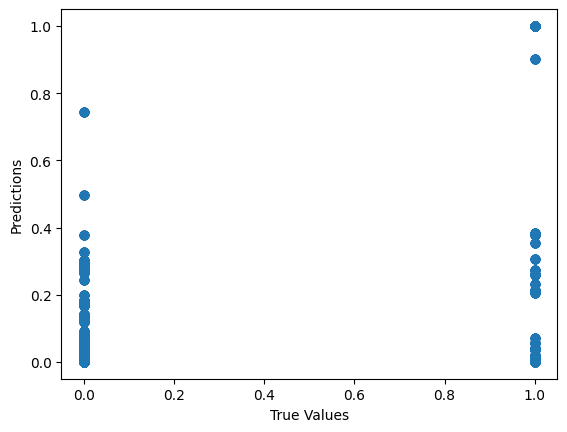

In [20]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [21]:
# metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(
    f"""
    R2-score: {r2} \n
    MAE: {mae} \n
    MSE: {mse} \n
    RMSE: {rmse} \n
"""
)


    R2-score: 0.5076571378593273 

    MAE: 0.15596445929526123 

    MSE: 0.12070329207168894 

    RMSE: 0.34742379318591426 




### SHAP (for feature importance)

In [22]:
sample = X_test.sample(n=2500, random_state=1)
sample

,year,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,CO_AVG,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
start_of_week,,,,,,,,,,,,,,,,,,,,,
2019-09-30,2019,3.0,1.973990,6.581793,4.914442,6.187543,2.554124,1.0,2.0,0.053829,...,0.006599,54.976935,15,0.00,0.00,0.00,0.00,0.00,0.00,97332020
2019-07-29,2019,2.0,1.700205,13.420944,7.560575,7.560575,8.287814,1.0,1.0,0.057400,...,0.001622,7.491233,24,628.65,9.44,0.00,0.00,0.00,0.00,97332086
2019-07-29,2019,4.0,3.036277,28.147844,13.526352,11.460644,10.526996,1.0,3.0,0.057400,...,0.001290,7.390577,23,2235.60,7.75,4.97,0.02,86.88,0.30,97332048
2019-07-29,2019,2.0,12.851472,19.036276,15.943874,15.943874,4.373317,0.0,2.0,0.056771,...,0.000059,0.358962,5,0.00,0.00,776.75,22.14,0.00,0.00,97332034
2020-01-27,2020,2.0,3.000000,17.000000,10.000000,10.000000,9.899495,2.0,0.0,0.082800,...,0.003791,36.095131,14,55.34,1.00,0.00,0.00,30.14,0.54,97332021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,2019,5.0,8.925393,64.262833,28.230527,20.268309,22.249256,3.0,2.0,0.055143,...,0.000761,4.904170,7,579.45,11.55,236.67,4.72,774.77,15.44,97332023
2019-10-28,2019,3.0,3.846680,13.319644,7.698836,5.930185,4.977987,2.0,1.0,0.059843,...,0.003284,27.311919,19,0.00,0.00,0.00,0.00,0.00,0.00,97332031
2019-07-29,2019,6.0,2.581793,43.994526,15.843487,12.275154,14.645139,3.0,3.0,0.057400,...,0.003791,36.095131,29,0.00,0.00,0.00,0.00,0.00,0.00,97332021


In [23]:
explainer = shap.Explainer(regressor)
shap_values = explainer.shap_values(sample)

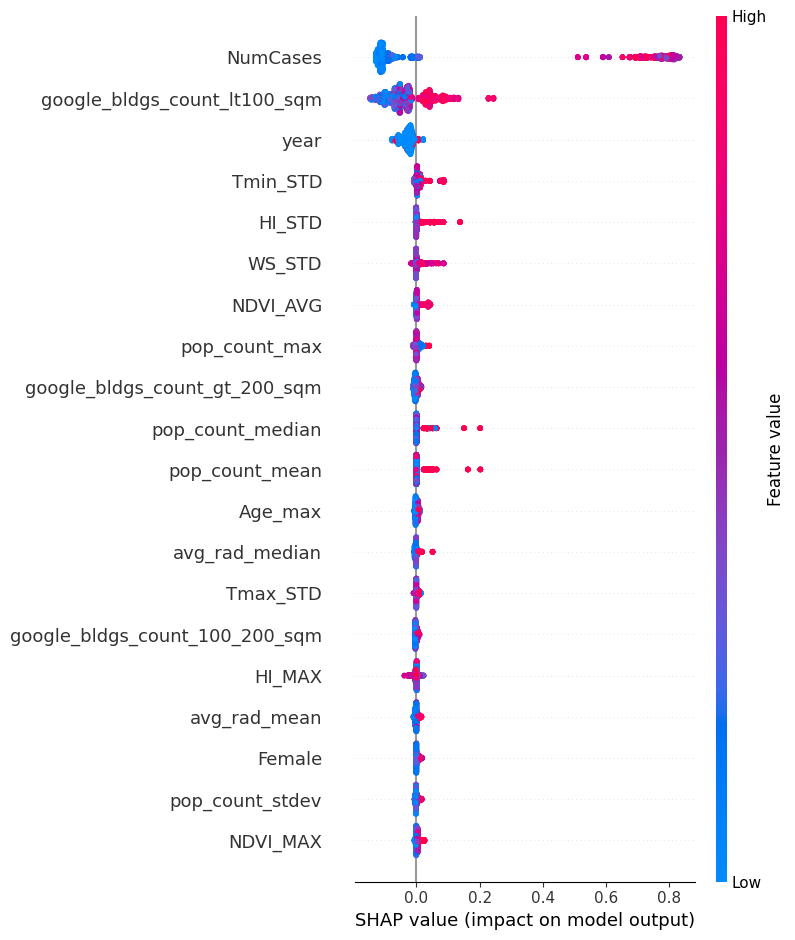

In [24]:
shap.summary_plot(shap_values, sample)

## RF Classifier

In [39]:
X_train.columns.tolist()

['year',
 'NumCases',
 'Age_min',
 'Age_max',
 'Age_mean',
 'Age_median',
 'Age_std',
 'Female',
 'Male',
 'CO_AVG',
 'CO_MIN',
 'CO_MAX',
 'CO_STD',
 'HI_AVG',
 'HI_MIN',
 'HI_MAX',
 'HI_STD',
 'NDVI_AVG',
 'NDVI_MIN',
 'NDVI_MAX',
 'NDVI_STD',
 'NO2_AVG',
 'NO2_MIN',
 'NO2_MAX',
 'NO2_STD',
 'O3_AVG',
 'O3_MIN',
 'O3_MAX',
 'O3_STD',
 'PM10_AVG',
 'PM10_MIN',
 'PM10_MAX',
 'PM10_STD',
 'PM25_AVG',
 'PM25_MIN',
 'PM25_MAX',
 'PM25_STD',
 'PNP_AVG',
 'PNP_MIN',
 'PNP_MAX',
 'PNP_STD',
 'PR_AVG',
 'PR_MIN',
 'PR_MAX',
 'PR_STD',
 'RH_AVG',
 'RH_MIN',
 'RH_MAX',
 'RH_STD',
 'SO2_AVG',
 'SO2_MIN',
 'SO2_MAX',
 'SO2_STD',
 'SPI3_AVG',
 'SPI3_MIN',
 'SPI3_MAX',
 'SPI3_STD',
 'SPI6_AVG',
 'SPI6_MIN',
 'SPI6_MAX',
 'SPI6_STD',
 'SR_AVG',
 'SR_MIN',
 'SR_MAX',
 'SR_STD',
 'Tave_AVG',
 'Tave_MIN',
 'Tave_MAX',
 'Tave_STD',
 'Tmax_AVG',
 'Tmax_MIN',
 'Tmax_MAX',
 'Tmax_STD',
 'Tmin_AVG',
 'Tmin_MIN',
 'Tmin_MAX',
 'Tmin_STD',
 'UVR_AVG',
 'UVR_MIN',
 'UVR_MAX',
 'UVR_STD',
 'WS_AVG',
 'WS_MIN',


In [25]:
X_train["NumCases"].describe()

count    19754.000000
mean         3.317910
std          1.964597
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         15.000000
Name: NumCases, dtype: float64

In [26]:
y_train.value_counts()

0    15854
1     3900
Name: outbreak, dtype: int64

In [27]:
clf_regressor = RandomForestClassifier(n_jobs=-1, n_estimators=400, random_state=42)
# Train the regressor on the training data
clf_regressor.fit(X_train, y_train)
# Make predictions on the test set
y_pred = clf_regressor.predict(X_test)
y_pred_proba = clf_regressor.predict_proba(X_test)

In [28]:
# Evaluate the model
score = clf_regressor.score(X_test, y_test)
score  # mean accuracy

0.7867557715674363

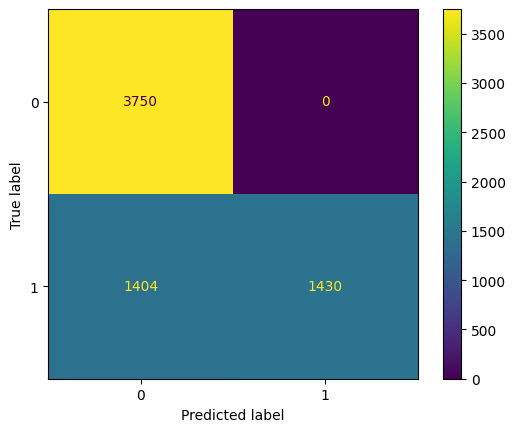

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf_regressor.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_regressor.classes_
)
disp.plot()
plt.show()

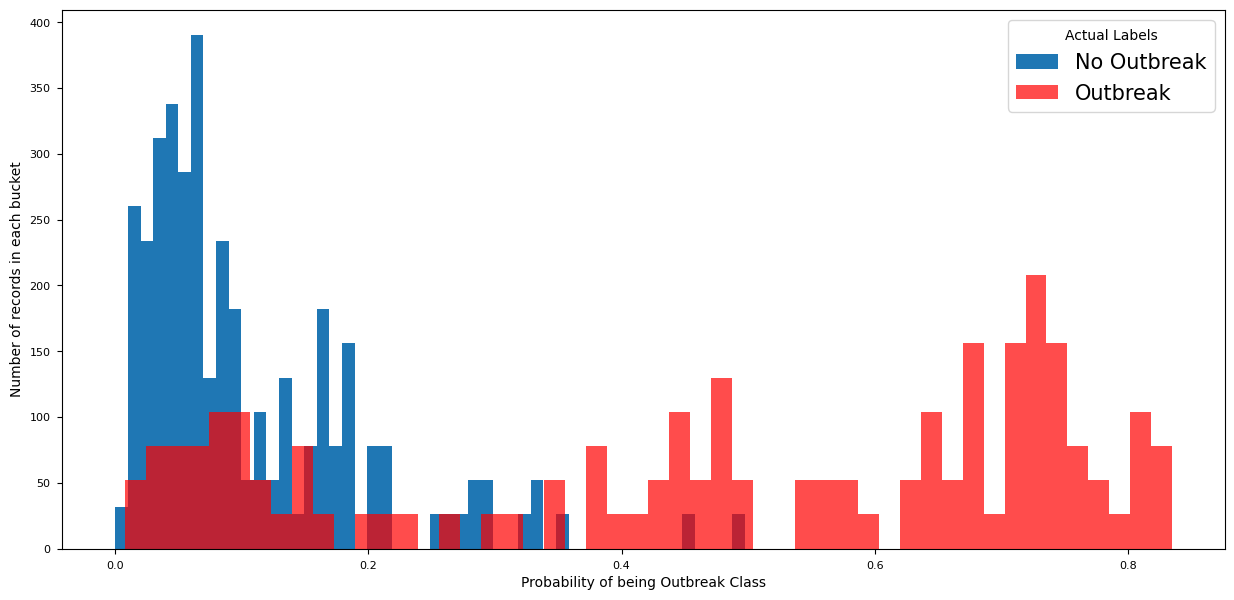

In [30]:
prediction = y_pred_proba[:, 1]  # prediction for outbreak
plt.figure(figsize=(15, 7))
plt.hist(prediction[y_test == 0], bins=50, label="No Outbreak")
plt.hist(prediction[y_test == 1], bins=50, label="Outbreak", alpha=0.7, color="r")
plt.xlabel("Probability of being Outbreak Class", fontsize=10)
plt.ylabel("Number of records in each bucket", fontsize=10)
plt.legend(fontsize=15, title="Actual Labels")
plt.tick_params(axis="both", labelsize=8, pad=5)
plt.show()

In [31]:
y_pred_proba

array([[1.    , 0.    ],
       [1.    , 0.    ],
       [1.    , 0.    ],
       ...,
       [0.9875, 0.0125],
       [0.9875, 0.0125],
       [0.9875, 0.0125]])

In [32]:
sample = X_test.sample(n=2500, random_state=1)
explainer = shap.Explainer(clf_regressor)
shap_values = explainer.shap_values(sample)

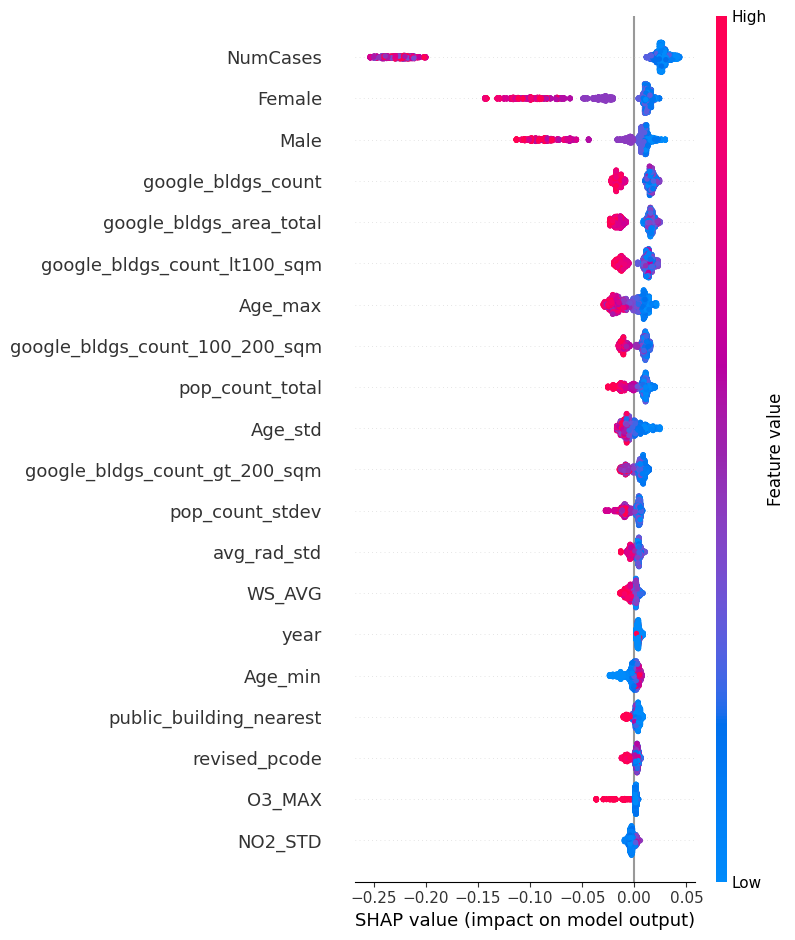

In [33]:
shap.summary_plot(shap_values[0], sample)